In [399]:
%matplotlib inline
import numpy as np
from skimage.draw import circle
from scipy import signal
from scipy import fftpack
import matplotlib.pyplot as plt

In [400]:
def wiener(y, h, S=1, N=0.1):
    """
    2D Wiener deconvolution. Implemented as defined in
    https://en.wikipedia.org/wiki/Wiener_deconvolution
    
    Parameters
    ----------
    y : 2D array
        The observed signal
    
    h : 2D array
        The impulse response (point spread function) of the system
    
    S : scalar or 2D array, optional
        This signal is used to calclate the power spectral density of the origininal signal.
    
    N : scalar or 2D array, optional
        This signal is used to calclate the power spectral density of the noise.
    
    Returns
    -------
    x : 2D array
        An estimate of the original signal.
    """
    
    shape = [sy + sh - 1  for sy, sh in zip(y.shape, h.shape)]
    Y = np.fft.rfft2(y, shape)
    H = np.fft.rfft2(h, shape)
    if not np.isscalar(N):
        N = np.absolute(np.fft.rfft2(N, shape))**2
    if not np.isscalar(S):
        S = np.absolute(np.fft.rfft2(S, shape))**2
    G = (np.conj(H) * S) / (np.absolute(H)**2 * S + N)
    X = G * Y
    shape_original = [sy - sh + 1  for sy, sh in zip(y.shape, h.shape)]
    x = np.fft.irfft2(X, shape)[:shape_original[0],:shape_original[1]].copy()
    return x

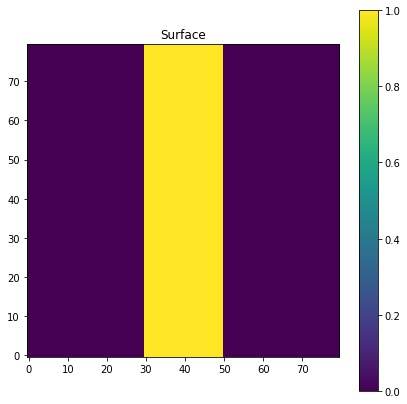

In [401]:
surface = np.zeros((80, 80))
surface[:,30:50]=1

plt.figure(figsize=(7,7))
plt.imshow(surface, origin='lower')
plt.colorbar()
plt.title("Surface");

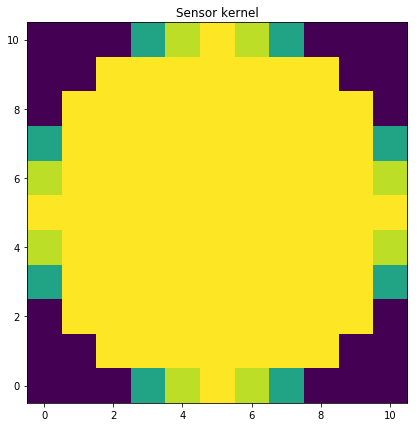

In [402]:
sensor_diameter = 11

r = sensor_diameter // 2
sensor_function = np.zeros((sensor_diameter, sensor_diameter))
rr, cc, val = circle_perimeter_aa(r, r, r)
sensor_function[rr, cc] = val
rr, cc, = circle(r, r, r)
sensor_function[rr, cc] = 1
sensor_function /= sensor_function.sum()

plt.figure(figsize=(7,7))
plt.imshow(sensor_function, origin='lower')
plt.title("Sensor kernel");

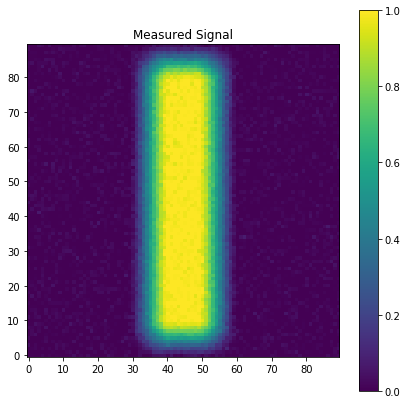

In [403]:
measured_signal = signal.convolve2d(surface, sensor_function)
noise = np.random.normal(0, 0.02, measured_signal.shape)
measured_signal += noise

plt.figure(figsize=(7,7))
plt.imshow(measured_signal, origin='lower', vmin=surface.min(), vmax=surface.max())
plt.colorbar()
plt.title("Measured Signal");

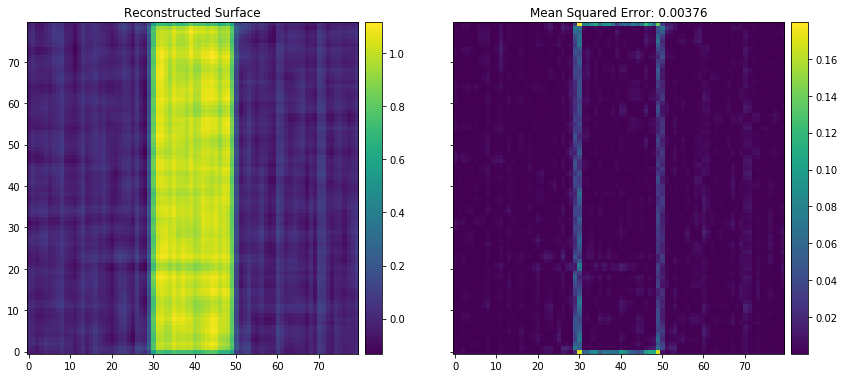

In [404]:
reconstruced_surface = wiener(measured_signal, sensor_function, surface, noise)
error = (reconstruced_surface - surface)**2

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,7))
im1 = ax1.imshow(reconstruced_surface, origin='lower')
im2 = ax2.imshow(error, origin='lower')

ax1.set_title("Reconstructed Surface")
ax2.set_title("Mean Squared Error: {:.3}".format(error.mean()))

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
f.colorbar(im1, cax=cax1)
f.colorbar(im2, cax=cax2);